### Importing libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns

### Reading Data

In [2]:
# load dataset
url = "./new_Base_CDM_balanced_V2.csv"
dataset = pd.read_csv(url)
columns = [[dataset[str(c)][0],c ]for c in dataset.columns]

dataset.drop(index=dataset.index[0], 
        axis=0, 
        inplace=True)
cols =pd.DataFrame(columns)
cols.transpose()

,0,1,2,3,4,5,6,7
0,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
1,Y,X1,X2,X3,X4,X5,X6,X7


In [3]:
#Renaming variables 
dataset.rename(columns = dict(zip(cols[1], cols[0])) , inplace = True)

In [4]:
dataset.head()

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature
1,No_Displ,2,20.2,47400,36,CORA,72,No_Feat
2,No_Displ,2,11.9,62000,24,LECLERC,48,No_Feat
3,No_Displ,8,29.52,60661,60,AUCHAN,480,No_Feat
4,No_Displ,2,16.2,59677,19,CARREFOUR,38,No_Feat
5,No_Displ,5,62.1,142602,50,CORA,250,No_Feat


In [5]:
quantitative_variables = ['cor_sales_in_vol', 'cor_sales_in_val', 'CA_mag', 'value', 'VenteConv']
for column_name in quantitative_variables :
    dataset[column_name]=dataset[column_name].astype(float)

Text(0.5, 1.0, 'Correlation Heatmap')

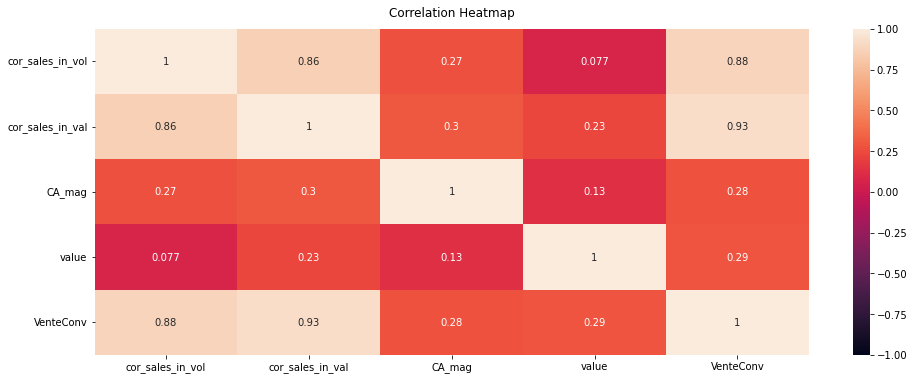

In [6]:
# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(dataset.iloc[:,[1,2,3,4,6]].corr() , vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

### ACP

In [7]:
from sklearn.decomposition import PCA
continuous_variables = dataset.iloc[:,[1,2,3,4,6]].values
pca = PCA(n_components=1)
new_continuous_variables = pca.fit_transform(continuous_variables)

In [8]:
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.99894282]
[8819343.08013713]


In [9]:
dataset["v1"] = new_continuous_variables

In [10]:
dataset.head(2)

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature,v1
1,No_Displ,2.0,20.2,47400.0,36.0,CORA,72.0,No_Feat,-17245.376600
2,No_Displ,2.0,11.9,62000.0,24.0,LECLERC,48.0,No_Feat,-2646.256414


In [11]:
from sklearn.preprocessing import KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=2 , encode="onehot-dense" , strategy='kmeans')
Xt = discretizer.fit_transform(dataset.loc[:,["v1"]].values)

In [12]:
dataset[["v_discretizer"]] = np.reshape(Xt[:,0],(-1,1))

In [18]:
dataset.head(1)

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature,v1,v_discretizer
1,No_Displ,2.0,20.2,47400.0,36.0,CORA,72.0,No_Feat,-17245.3766,1.0


In [19]:
dataset["v_discretizer2"] = [ "no" if i==1.0 else "yes" for i in dataset["v_discretizer"] ]

In [20]:
dataset.head(1)

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature,v1,v_discretizer,v_discretizer2
1,No_Displ,2.0,20.2,47400.0,36.0,CORA,72.0,No_Feat,-17245.3766,1.0,no


In [16]:
pd.crosstab(a, [b, c], rownames=['a'], colnames=['b', 'c'])

,Display,cor_sales_in_vol,cor_sales_in_val,CA_mag,value,ENSEIGNE,VenteConv,Feature,v1,v_discretizer
1,No_Displ,2.0,20.2,47400.0,36.0,CORA,72.0,No_Feat,-17245.376600,1.0
2,No_Displ,2.0,11.9,62000.0,24.0,LECLERC,48.0,No_Feat,-2646.256414,1.0


In [1]:
import numpy as np

def supervised_discretize(X, y, num_bins=10):
    """
    Perform supervised discretization of a continuous feature using the MDLPC algorithm.
    
    Parameters:
    - X (1D array): Continuous feature to discretize.
    - y (1D array): Target labels.
    - num_bins (int): Number of bins to use for discretization.
    
    Returns:
    - bin_edges (1D array): Bin edges for discretized feature.
    """
    # Sort X and y in ascending order of X
    X, y = zip(*sorted(zip(X, y)))
    
    # Initialize list of bin edges
    bin_edges = [X[0]]
    
    # Initialize minimum description length
    min_description_length = float("inf")
    
    # Iterate over all possible bin splits
    for i in range(1, len(X)):
        # Calculate entropy gain and description length of current split
        entropy_gain, description_length = calc_mdl(y[:i], y[i:])
        
        # If description length is lower than current minimum, update minimum and add current value of X as a bin edge
        if description_length < min_description_length:
            min_description_length = description_length
            bin_edges.append(X[i])
            
        # If number of bin edges exceeds num_bins, return the bin edges
        if len(bin_edges) > num_bins:
            return bin_edges
    
    # Return bin edges
    return bin_edges

def calc_mdl(y1, y2):
    """
    Calculate the entropy gain and description length of a split of a continuous feature.
    
    Parameters:
    - y1 (1D array): Target labels for first group of feature values.
    - y2 (1D array): Target labels for second group of feature values.
    
    Returns:
    - entropy_gain (float): Entropy gain of the split.
    - description_length (float): Description length of the split.
    """
    # Calculate entropy gain of the split
    entropy_gain = calc_entropy_gain(y1, y2)
    
    # Calculate size of first and second groups
    size_1 = len(y1)
    size_2 = len(y2)
    
    # Calculate number of bits required to describe the split
    description_length = np.log2(size_1 + size_2) + (size_1 / (size_1 + size_2)) * np.log2(size_1) + (size_2 / (size_1 + size_2)) * np.log2(size_2)
    
    return entropy_gain, description_length

def calc_entropy_gain(y1, y2):
    """
    Calculate the entropy gain of a split of a continuous feature.
    
    Parameters:
    - y1 (1D array): Target labels for first group of feature values.
    - y2 (1D array): Target labels for second group of feature values.
    
    Returns:
    - entropy_gain (float): Entropy gain of the split.
    """
    # Calculate entropy of entire dataset
    entropy_total = calc_entropy(np.concatenate((y1, y2)))
    
    # Calculate entropy of first group
    entropy_1 = calc_entropy(y1)
    
    # Calculate entropy of second group
    entropy_2 = calc_entropy(y2)
    
    # Calculate size of first and second groups
    size_1 = len(y1)
    size_2 = len(y2)
    
    # Calculate weighted average of entropies
    entropy_avg = (size_1 / (size_1 + size_2)) * entropy_1 + (size_2 / (size_1 + size_2)) * entropy_2
    
    # Return entropy gain
    return entropy_total - entropy_avg

def calc_entropy(y):
    """
    Calculate the entropy of a group of target labels.
    
    Parameters:
    - y (1D array): Target labels.
    
    Returns:
    - entropy (float): Entropy of the group.
    """
    # Get unique target labels
    labels = np.unique(y)
    
    # Initialize entropy
    entropy = 0
    
    # Calculate probability of each class
    for label in labels:
        p = np.sum(y == label) / len(y)
        
        # Add to entropy
        if p > 0:
            entropy -= p * np.log2(p)
    
    return entropy







c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.el2c6ple4zyw3eceviv3oxxgrn2nrfm2.gfortran-win_amd64.dll
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
c:\Users\hp\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Generate some random continuous feature and target labels
np.random.seed(0)
X = np.random.normal(size=100)
y = np.random.randint(0, 2, size=100)

# Define number of folds for cross-validation
num_folds = 5

# Define range of values for num_bins
num_bins_range = range(2, 20)

# Initialize dictionary to store results
results = {}

# Create KFold object
kf = KFold(n_splits=num_folds)

# Iterate over num_bins values
for num_bins in num_bins_range:
    # Initialize list to store accuracy scores for current value of num_bins
    scores = []
    
    # Iterate over folds
    for train_index, val_index in kf.split(X):
        # Get train and validation sets
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        # Perform supervised discretization on train set
        bin_edges = supervised_discretize(X_train, y_train, num_bins=num_bins)
        
        # Discretize train and validation sets using bin edges
        X_train_discrete = np.digitize(X_train, bin_edges)
        X_val_discrete = np.digitize(X_val, bin_edges)
        
        # Train logistic regression model on discretized train set
        model = LogisticRegression()
        model.fit(X_train_discrete.reshape(-1, 1), y_train)
        
        # Predict on discretized validation set
        y_pred = model.predict(X_val_discrete.reshape(-1, 1))
        
        # Calculate accuracy score
        score = accuracy_score(y_val, y_pred)
        
        # Add score to list
        scores.append(score)
    
    # Calculate mean accuracy score for current value of num_bins
    mean_score = np.mean(scores)
    
    # Add mean score to results dictionary
    results[num_bins] = mean_score
    
# Print results
print(results)

# Find num_bins value with highest mean accuracy score
best_num_bins = max(results, key=results.get)
print(f"Best num_bins: {best_num_bins}")


{2: 0.5700000000000001, 3: 0.5700000000000001, 4: 0.5700000000000001, 5: 0.5700000000000001, 6: 0.59, 7: 0.59, 8: 0.59, 9: 0.59, 10: 0.59, 11: 0.59, 12: 0.59, 13: 0.59, 14: 0.59, 15: 0.59, 16: 0.59, 17: 0.59, 18: 0.59, 19: 0.59}
Best num_bins: 6


In [3]:

import numpy as np

# Generate some random continuous feature and target labels
np.random.seed(0)
X = np.random.normal(size=100)
y = np.random.randint(0, 2, size=100)

# Perform supervised discretization with 10 bins
bin_edges = supervised_discretize(X, y, num_bins=6)
print(bin_edges)

# Discretize feature using bin edges
X_discrete = np.digitize(X, bin_edges)

# Print first 10 values of original and discretized features
print(X[:10])
print(X_discrete[:10])

[-2.5529898158340787, -1.980796468223927, -1.7262826023316769, -1.7062701906250126, -1.6301983469660446, -1.6138978475579515, -1.5362436862772237]
[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985 ]
[7 7 7 7 7 7 7 7 7 7]


In [4]:
set(X_discrete)

{1, 2, 3, 4, 5, 6, 7}